In [ ]:
# ✅ STEP 1: Install required libraries
!pip install tensorflow tensorflow_datasets scikit-image


In [ ]:
# ✅ STEP 2: Load and preprocess Oxford Flowers 102 dataset
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from skimage.color import rgb2lab, lab2rgb
import matplotlib.pyplot as plt

# Load a small portion of the dataset
dataset = tfds.load('oxford_flowers102', split='train[:10%]', as_supervised=True)

def preprocess(img, label):
    img = tf.image.resize(img, (128, 128)) / 255.0
    return img

images = []
for img, lbl in dataset.take(200):  # Use 200 images for demo
    images.append(preprocess(img, lbl).numpy())

images = np.array(images)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.BZC7PV_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.BZC7PV_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.BZC7PV_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [ ]:
images = []
for img, lbl in dataset.take(200):  # Use 200 samples for now
    images.append(preprocess(img, lbl).numpy())
images = np.array(images)


In [ ]:
from skimage.color import rgb2lab

def prepare_lab(images):
    X_l = []
    Y_ab = []
    for img in images:
        lab = rgb2lab(img)  # Convert to LAB
        X_l.append(lab[:, :, 0:1])            # L channel only
        Y_ab.append(lab[:, :, 1:3] / 128.0)   # Normalize ab to [-1, 1]
    return np.array(X_l), np.array(Y_ab)

X_l, Y_ab = prepare_lab(images)
print("Grayscale input shape:", X_l.shape)
print("Color output shape:", Y_ab.shape)


Grayscale input shape: (102, 128, 128, 1)
Color output shape: (102, 128, 128, 2)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer

model = Sequential([
    InputLayer(input_shape=(128, 128, 1)),

    # Encoder
    Conv2D(64, (3,3), activation='relu', padding='same'),
    Conv2D(128, (3,3), activation='relu', padding='same', strides=2),
    Conv2D(256, (3,3), activation='relu', padding='same', strides=2),

    # Decoder
    UpSampling2D((2, 2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    Conv2D(2, (3,3), activation='tanh', padding='same')  # Output: ab channels
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 128, 128, 2)         │           1,154 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 739,650 (2.82 MB)

 Trainable params: 739,650 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_l, Y_ab, batch_size=8, epochs=50)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - loss: 0.9812
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - loss: 1.1324
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - loss: 1.0948
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - loss: 0.8368
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - loss: 0.0914
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - loss: 0.0357
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - loss: 0.0346
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - loss: 0.0362
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - loss: 0.0373
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - loss: 0.0347
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - loss: 0.0367
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - loss: 0.0363
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - loss: 0.0339
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - loss: 0.0352
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - loss: 0.0361
Epoch 16/50
13/13 ━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


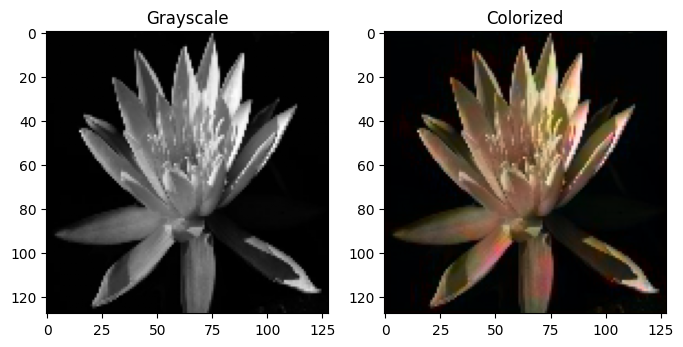

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


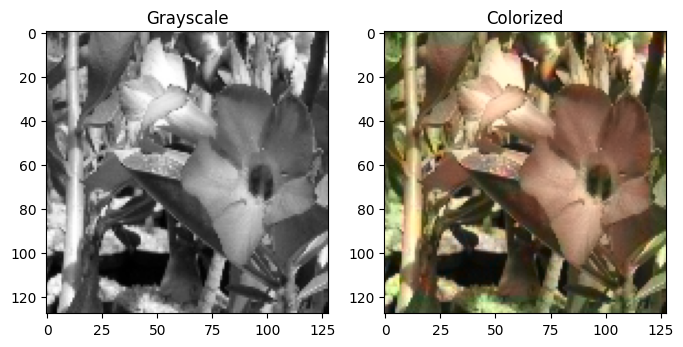

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


<ipython-input-18-a3f171ba2d76>:10: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(lab_img)


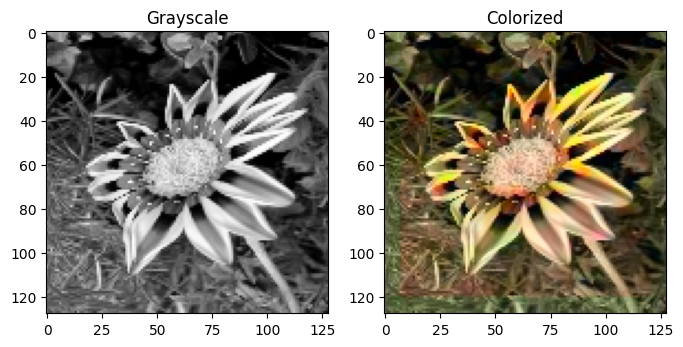

In [ ]:
from skimage.color import lab2rgb
import matplotlib.pyplot as plt

def visualize(index):
    l_input = X_l[index:index+1]
    ab_pred = model.predict(l_input)
    ab_pred = ab_pred * 128  # denormalize ab

    lab_img = np.concatenate([l_input[0], ab_pred[0]], axis=2)
    rgb_img = lab2rgb(lab_img)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(l_input[0][:,:,0], cmap='gray')
    plt.title('Grayscale')

    plt.subplot(1, 2, 2)
    plt.imshow(rgb_img)
    plt.title('Colorized')
    plt.show()

# Try some outputs
visualize(0)
visualize(1)
visualize(2)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 64)   │            640 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 128, 128, 64)   │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 64)     │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 64, 64, 128)    │            512 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 128)    │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 32, 32, 256)    │          1,024 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_7           │ (None, 64, 64, 256)    │              0 │ batch_normalization_7… │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 64, 64, 384)    │              0 │ up_sampling2d_7[0][0], │
│ (Concatenate)             │                        │                │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 64, 64, 128)    │        442,496 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 64, 64, 128)    │            512 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_8           │ (None, 128, 128, 128)  │              0 │ batch_normalization_8… │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3        

 Total params: 926,530 (3.53 MB)

 Trainable params: 925,250 (3.53 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - loss: 0.4188
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - loss: 0.0596
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - loss: 0.0470
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - loss: 0.0380
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - loss: 0.0381
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step - loss: 0.0421
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - loss: 0.0370
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - loss: 0.0400
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - loss: 0.0385
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 70s 5s/step - loss: 0.0349
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - loss: 0.0361
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - loss: 0.0368
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 69s 5s/step - loss: 0.0367
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 69s 5s/step - loss: 0.0415
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step - loss: 0.0336
Epoch 16/50
13/13 

<ipython-input-20-682ac223201a>:78: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 30 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(lab_img)


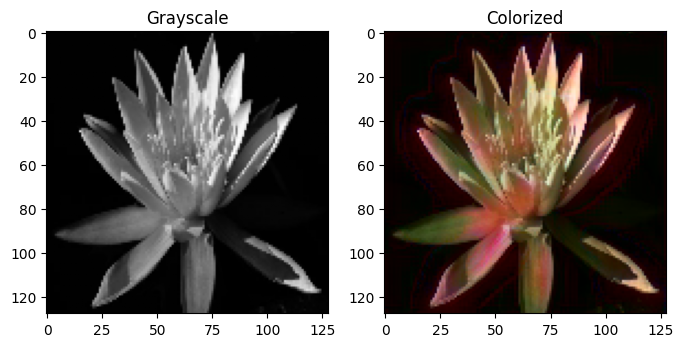

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


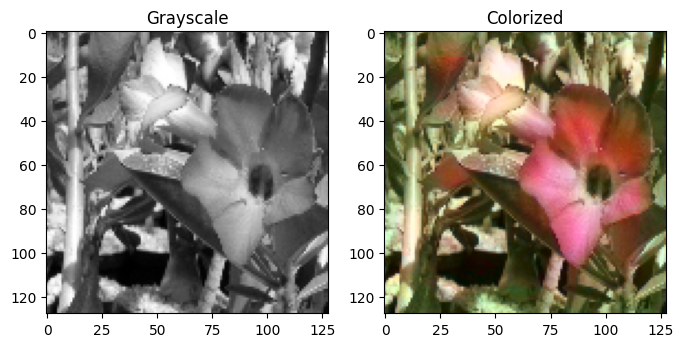

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


<ipython-input-20-682ac223201a>:78: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(lab_img)


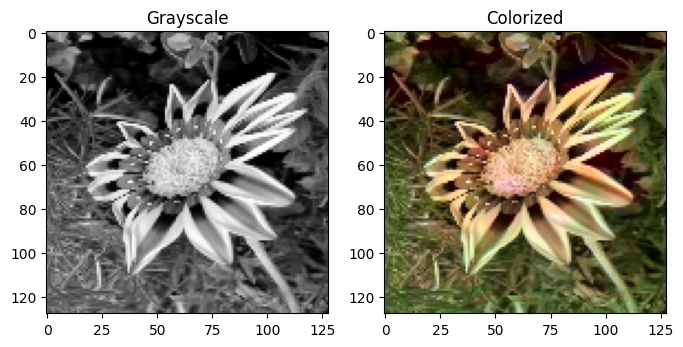

In [ ]:
# ✅ ADVANCED FLOWER COLORIZATION WITH U-NET
# Using Oxford Flowers 102 Dataset (TensorFlow + Keras)

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from skimage.color import rgb2lab, lab2rgb
import matplotlib.pyplot as plt

# --- Step 1: Load & Resize Dataset ---
def preprocess(img, label):
    img = tf.image.resize(img, (128, 128)) / 255.0
    return img

data = tfds.load('oxford_flowers102', split='train[:10%]', as_supervised=True)
images = [preprocess(img, lbl).numpy() for img, lbl in data.take(200)]
images = np.array(images)

# --- Step 2: Convert to LAB (L for input, ab for output) ---
def prepare_lab(images):
    X_l, Y_ab = [], []
    for img in images:
        lab = rgb2lab(img)
        X_l.append(lab[:, :, 0:1])
        Y_ab.append(lab[:, :, 1:3] / 128.0)
    return np.array(X_l), np.array(Y_ab)

X_l, Y_ab = prepare_lab(images)

# --- Step 3: Build U-Net Model for Colorization ---
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization
from tensorflow.keras.models import Model

def unet_colorization():
    inputs = Input(shape=(128, 128, 1))

    # Encoder
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)

    # Decoder
    u1 = UpSampling2D((2,2))(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(128, (3,3), activation='relu', padding='same')(u1)
    c4 = BatchNormalization()(c4)

    u2 = UpSampling2D((2,2))(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(64, (3,3), activation='relu', padding='same')(u2)
    c5 = BatchNormalization()(c5)

    output = Conv2D(2, (3,3), activation='tanh', padding='same')(c5)

    model = Model(inputs, output)
    return model

model = unet_colorization()
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Step 4: Train the Model ---
model.fit(X_l, Y_ab, batch_size=8, epochs=50)

# --- Step 5: Visualization Function ---
def visualize(index):
    l_input = X_l[index:index+1]
    ab_pred = model.predict(l_input)
    ab_pred = ab_pred * 128
    lab_img = np.concatenate([l_input[0], ab_pred[0]], axis=2)
    rgb_img = lab2rgb(lab_img)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(l_input[0][:,:,0], cmap='gray')
    plt.title('Grayscale')

    plt.subplot(1, 2, 2)
    plt.imshow(rgb_img)
    plt.title('Colorized')
    plt.show()

# Try visualization
visualize(0)
visualize(1)
visualize(2)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil

src = "/root/tensorflow_datasets/oxford_flowers102"
dst = "/content/drive/MyDrive/oxford_flowers102"

shutil.copytree(src, dst)
print("✅ Dataset copied to Google Drive successfully!")


✅ Dataset copied to Google Drive successfully!


In [ ]:
import shutil
import os

# Source location (where TensorFlow Datasets stored it)
source_path = "/root/tensorflow_datasets/oxford_flowers102"

# Destination in your Google Drive
destination_path = "/content/drive/MyDrive/tensorflow_datasets/oxford_flowers102"

# Only copy if it doesn't already exist
if not os.path.exists(destination_path):
    shutil.copytree(source_path, destination_path)
    print("✅ Dataset copied permanently to your Drive!")
else:
    print("📁 Dataset already exists in your Drive.")


✅ Dataset copied permanently to your Drive!
